In [58]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

import torch
import torch.autograd
from torch.optim import AdamW, SGD, Adam
import torch.nn

import random
import stim
import stim_model
import cpn_model
import utils


# A 'Thing' is the thing we are stimulating. It is basically
# a single variable diffeq-goverened system that merely dampens
# over time, except a stimulation can excite it.
class Thing(object):
    def __init__(self, init=0.0, decay=0.7):
        assert isinstance(init, float)
        self.x = init
        self.decay = decay

    def observe(self):
        return self.x

    def step(self, input):
        assert isinstance(input, float)
        self.x += input
        self.x = self.decay * self.x
        

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [59]:
# Problem 1:
# We will recapitulate sine waves with various starting
# phases. 'steps' is the trial length
steps = 200
batch_size = 256
# y=target, x=phase
target = torch.zeros((batch_size, steps, 2))
for bidx in range(batch_size):
    offset = bidx / float(batch_size)
    for i in range(steps):
        t = torch.tensor(6 * (i / 100.0) + offset)
        target[bidx, i, 0] = torch.sin(t)
        target[bidx, i, 1] = t
        
target = target[torch.randperm(target.shape[0]), :, :]

In [60]:
# Problem 2:
# Alternate, more difficult problem that involves memory.
# Learning isn't working here yet.
# We will recapitulate sine waves with various starting
# frequencies. 'steps' is the trial length
steps = 100
show_steps = 10
hold_steps = 20
batch_size = 256
# y=target, x=(target freq, hold signal)
target = torch.zeros((batch_size, steps, 3))
for bidx in range(batch_size):
    freq = bidx * 15 / float(batch_size) + 2
    x = bidx / float(batch_size)
    for i in range(steps):     
        # This is a harder problem involving memory, which looks
        # a lot like the the Michaels problem
        # Dim 1: the target value
        if i < hold_steps:
            target[bidx, i, 0] = 0.0
        else:
            t = torch.tensor(freq * ((i - hold_steps)/ 100.0))
            target[bidx, i, 0] = torch.sin(t)
        
        # Dim 2: the target freq
        if i < show_steps:
            target[bidx, i, 1] = torch.tensor(x)
        else:
            target[bidx, i, 1] = 0.0
            
        # Dim 3: the hold signal
        if i < hold_steps:
            target[bidx, i, 2] = 1.0
        else:
            target[bidx, i, 2] = 0.0

In [63]:
# Train a BEN on a collection of CPNs, centered at the given CPN,
#  with mean 0 noise added to the weights.

      
def make_noised_cpn(cpn, var=0.1):
    cpn_out = cpn_model.CPNModel(cpn.in_dim, cpn.out_dim, num_neurons=cpn.num_neurons,
                                 activation_func=cpn.activation_func_t)
    cpn_out.load_state_dict(cpn.state_dict())
    
    with torch.no_grad():
        for p in cpn_out.parameters():
            noise = var * (torch.rand(p.shape) - 0.5)
            p.data = p.data + p.data * noise
            
    return cpn_out

def train_a_ben(cpn, ben=None, last_loss=1):
    global recent_ben
    
    # An observation of a 1 dimensional thing, 1 dimension of stimulation, 1 dimension 'x'
    if ben is None or last_loss > 0.05:
        ben = stim_model.StimModelLSTM(target.shape[-1] + 1, 1, num_neurons=20,
                                   activation_func=torch.nn.Tanh)
        recent_ben = ben
    vl = torch.ones(1)
    opt_ben = AdamW(ben.parameters(), lr=9e-3, weight_decay=0.02)

    checkpoint_eidx = 0
    for eidx in range(10000000):
        opt_ben.zero_grad()
        ben.reset()
        cpn.reset()
        loss = torch.nn.MSELoss()
        all_obs = torch.zeros(batch_size, steps, requires_grad=False)
        preds = torch.zeros(batch_size, steps)
        
        for p in opt_ben.param_groups:
            if eidx < 3:
                p['lr'] = 2e-2
            else:
                #p['lr'] = min(max(1e-4, 0.4192 * vl.item()), 3e-3)
                #p['lr'] = min(max(1e-3, 0.4192 * vl.item()), 3e-3)
                if vl.item() < 0.005:
                    p['lr'] = 5e-3
                else:
                    p['lr'] = 9e-3
                
    
        random_targets = target[torch.randperm(target.shape[0]), :, :]
        cpn_noise = cpn_model.CPNNoiseyLSTMCollection(cpn, noise_var=(0.1 * last_loss))
        # Just in case...
        for param in cpn_noise.parameters():
            param.requires_grad=False
            
        things = [Thing(init=x.item()) for x in random_targets[:, 0, 0]]
        s = stim.StimulusGaussianExp(1, 1, batch_size=batch_size, pad_right_neurons=1)
        for tidx in range(steps):
            obs = [t.observe() for t in things]
            new_obs = torch.tensor(obs, requires_grad=False).reshape(256,1)
            all_obs[:, tidx:tidx+1] = new_obs
          
            x = random_targets[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            cpn_in = torch.cat((new_obs, x), axis=1)
            new_stim = cpn_noise(cpn_in)
        
            x = random_targets[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            ben_in = torch.cat((new_obs, new_stim, x), axis=1)
            cur_pred = ben(ben_in)
            preds[:, tidx] = cur_pred.squeeze()
        
            s.add(new_stim)
            n = s.get_next().detach().numpy()

            for bidx in range(batch_size):
                things[bidx].step(n[bidx, 0].item())
        
        rl = loss(preds, all_obs)
        rl.backward()
        opt_ben.step()
        
        # Verify against the actual CPN
        things = [Thing(init=x.item()) for x in random_targets[:, 0, 0]]
        s = stim.StimulusGaussianExp(1, 1, batch_size=batch_size, pad_right_neurons=1)
        obs_val = torch.zeros(batch_size, steps)
        preds_val = torch.zeros(batch_size, steps)
        opt_ben.zero_grad()
        cpn.reset()
        ben.reset()
        for tidx in range(steps):
            obs = [t.observe() for t in things]
            new_obs = torch.tensor(obs).reshape(256,1)
            obs_val[:, tidx:tidx+1] = new_obs
          
            x = random_targets[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            cpn_in = torch.cat((new_obs, x), axis=1)
            new_stim = cpn(cpn_in)
        
            x = random_targets[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            ben_in = torch.cat((new_obs, new_stim, x), axis=1)
            cur_pred = ben(ben_in)
            preds_val[:, tidx] = cur_pred.squeeze()
        
            s.add(new_stim)
            n = s.get_next().detach().numpy()

            obs = []
            for bidx in range(batch_size):
                things[bidx].step(n[bidx, 0].item())
        
        vl = loss(preds_val, obs_val)
        print("ben", eidx, rl.item(), "first 80:",
              loss(preds[:80, :], all_obs[:80, :]).item(),
              "val:", vl.item())
                
        if torch.isnan(vl) or torch.isinf(vl) or vl.item() > 1.5 or (eidx - checkpoint_eidx) > 5000:
            # Emergency eject button
            ben = stim_model.StimModelLSTM(ben.in_dim, ben.out_dim, num_neurons=ben.num_neurons,
                                       activation_func=ben.activation_func_t)
            recent_ben = ben
            opt_ben = AdamW(ben.parameters(), lr=1e-3, weight_decay=0.02)
            checkpoint_eidx = eidx
            
        if vl.item() < max(0.01 * last_loss, 0.0007) and eidx > 200:
            opt_ben.zero_grad()
            break
            
    return ben

In [ ]:
# @preston: this is the core learning algorithm, and seems to be
# able to converge if the problem is structured in a sane way.
#
# In essence: this training loop trains until the (B)EN reaches a
#  certain threshold of loss on the untrained CPN. This can take
#  awhile to converge. Once it does, the CPN will be trained. The
#  BEN is then retrained until it converges again. That way: we only
#  ever train the CPN on an 'accurate' BEN.
#
# Adding the "label" input, which is the second column in target, is
# necessary. Alternatively once could start every trial at the same
# phase - basically memorizing one exact sine wave.


#  1 dimension of stim param, output

cpn = cpn_model.CPNModelLSTM(target.shape[-1], 1, num_neurons=20, activation_func=torch.nn.Tanh)
#cpn.load_state_dict(torch.load('latest_cpn'))
opt_cpn = AdamW(cpn.parameters(), lr=1e-4)

loss = torch.nn.MSELoss()

rli = 0.02

cpn_losses = []
super_epoch_count = 0
ben = recent_ben
while True:       
    super_epoch_count += 1
    
    for param in cpn.parameters():
        param.requires_grad=False
    # @preston: retraining an existing ben doesn't work - it never converges.
    
    #    ben = train_a_ben(cpn, ben=ben, last_loss=rli)
    #if super_epoch_count > 1:
    ben = train_a_ben(cpn, last_loss=rli)
    #bens.append(ben)
    for param in cpn.parameters():
        param.requires_grad=True
    for param in ben.parameters():
        param.requires_grad=False
        
    recent_losses = []
    for eidx in range(5000):
        opt_cpn.zero_grad()
        cpn.reset()
        ben.reset()
    
        thing = [Thing(init=x.item()) for x in target[:, 0, 0].detach().numpy()]
    
        pred = torch.zeros((256, steps))
        # This is actually very simple in our single variable context: it outputs
        # a stimulation value which decays to 0 over time.
        # The 'padding' is a cludgy, ugly thing that you can ignore; it's for
        #  the purpose of applying to the Michaels model. I may remove it later.
        s = stim.StimulusGaussianExp(1, 1, batch_size=256, pad_right_neurons=1)
    
        all_obs = torch.zeros(256, steps)
        stims = []

        for tidx in range(steps):
            obs = [t.observe() for t in thing]
            new_obs = torch.tensor(obs, requires_grad=False).reshape(256,1)
            all_obs[:, tidx:tidx+1] = new_obs
          
            x = target[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            cpn_in = torch.cat((new_obs, x), axis=1)
            new_stim = cpn(cpn_in)
            new_stim.retain_grad()
        
            x = target[:, tidx, 1:].reshape(256, target.shape[-1] - 1)
            ben_in = torch.cat((new_obs, new_stim, x), axis=1)
            cur_pred = ben(ben_in)
            pred[:, tidx] = cur_pred.squeeze()
        
            s.add(new_stim)
            stims.append(new_stim)
            n = s.get_next().detach().numpy()

            for bidx in range(batch_size):
                thing[bidx].step(n[bidx, 0].item())

            
        rl = loss(pred, target[:, :, 0])
        rli = rl.item()
        rl.backward()  

        real_loss = loss(all_obs, target[:, :, 0])
        print("cpn", eidx, rl.item(), loss(pred, all_obs).item(), real_loss.item())
        recent_losses.append(real_loss.item())
                                                  
        # Emergency bailout; we diverged; start over :(
        if recent_losses[-1] > 2.0:
            cpn = cpn_model.CPNModelLSTM(target.shape[-1], cpn.out_dim,
                                     num_neurons=cpn.num_neurons,
                                     activation_func=cpn.activation_func_t)
            opt_cpn = AdamW(cpn.parameters(), lr=1e-4)
            break
                    
        torch.save(cpn.state_dict(), "latest_cpn")
        torch.save(ben.state_dict(), "latest_ben")
            
        # Emergency bailout; time to retrain ben
        if len(recent_losses) > 12 and (recent_losses[-1] > recent_losses[0] * 1.2):
            ben = None
            break
        # Done
        elif rli < 0.003:
            break
        elif len(recent_losses) > 12:
            prev = None
            num_regressed = 0
            for l in recent_losses[-12:]:
                if prev is not None and l > prev:
                    num_regressed += 1
                        
                prev = l
            
            if num_regressed > 3 and loss(pred, all_obs).item() > rli or num_regressed > 8:
                if eidx < 20:
                    ben = None
                break
              
        cpn_losses.append(rli)
        opt_cpn.step()
        
    if rli < 0.003:
        break

plt.plot(pred[-1,:].detach().numpy())
plt.plot(all_obs[-1,:].detach().numpy())
plt.plot(target[-1, :, 0].detach().numpy())
plt.show()

ben 0 0.2148893028497696 first 80: 0.21494264900684357 val: 0.12618112564086914
ben 1 0.1261187195777893 first 80: 0.1261022388935089 val: 0.05917096510529518
ben 2 0.0591583214700222 first 80: 0.059173665940761566 val: 0.009637396782636642
ben 3 0.00964117981493473 first 80: 0.009659153409302235 val: 0.0028274101205170155
ben 4 0.0028277216479182243 first 80: 0.0029183158185333014 val: 0.005984891206026077
ben 5 0.005984627641737461 first 80: 0.0058812047354876995 val: 0.012097572907805443
ben 6 0.012098520062863827 first 80: 0.012052231468260288 val: 0.010434682480990887
ben 7 0.010433911345899105 first 80: 0.01037800032645464 val: 0.005692474078387022
ben 8 0.005696890410035849 first 80: 0.005711628124117851 val: 0.0023755065631121397
ben 9 0.0023755235597491264 first 80: 0.0023363300133496523 val: 0.0015924694016575813
ben 10 0.0015923130558803678 first 80: 0.0015912499511614442 val: 0.0014030769234523177
ben 11 0.0014027018332853913 first 80: 0.0013949618441984057 val: 0.001576150

ben 94 6.448920612456277e-05 first 80: 6.438065611291677e-05 val: 6.394844967871904e-05
ben 95 6.40444050077349e-05 first 80: 6.30024733254686e-05 val: 6.36773111182265e-05
ben 96 6.393682997440919e-05 first 80: 6.31311850156635e-05 val: 6.328045128611848e-05
ben 97 6.373026553774253e-05 first 80: 6.060703890398145e-05 val: 6.277758802752942e-05
ben 98 6.307780859060585e-05 first 80: 6.235181353986263e-05 val: 6.223443779163063e-05
ben 99 6.252819002838805e-05 first 80: 6.12376825301908e-05 val: 6.172715802676976e-05
ben 100 6.215514440555125e-05 first 80: 6.0560196288861334e-05 val: 6.130296969786286e-05
ben 101 6.15860553807579e-05 first 80: 6.470674270531163e-05 val: 6.094883065088652e-05
ben 102 6.120899342931807e-05 first 80: 6.101351755205542e-05 val: 6.0628655774053186e-05
ben 103 6.0936166846659034e-05 first 80: 5.836850687046535e-05 val: 6.03076332481578e-05
ben 104 6.073272743378766e-05 first 80: 6.217349437065423e-05 val: 5.996113031869754e-05
ben 105 6.032489545759745e-05 f

ben 186 3.636073233792558e-05 first 80: 3.4537279134383425e-05 val: 3.5744149499805644e-05
ben 187 3.599105548346415e-05 first 80: 3.703935362864286e-05 val: 3.5520813980838284e-05
ben 188 3.594886584323831e-05 first 80: 3.507598739815876e-05 val: 3.529661989887245e-05
ben 189 3.557803574949503e-05 first 80: 3.538901000865735e-05 val: 3.507268411340192e-05
ben 190 3.534882853273302e-05 first 80: 3.537332304404117e-05 val: 3.484863555058837e-05
ben 191 3.523411578498781e-05 first 80: 3.478616417851299e-05 val: 3.462404492893256e-05
ben 192 3.484689295873977e-05 first 80: 3.6288241972215474e-05 val: 3.440240470808931e-05
ben 193 3.4677206713240594e-05 first 80: 3.5334927815711126e-05 val: 3.418233245611191e-05
ben 194 3.444506000960246e-05 first 80: 3.427752744755708e-05 val: 3.396408283151686e-05
ben 195 3.425404065637849e-05 first 80: 3.662302697193809e-05 val: 3.374859079485759e-05
ben 196 3.400553032406606e-05 first 80: 3.48773792211432e-05 val: 3.3534994145156816e-05
ben 197 3.38486

cpn 102 0.5249021649360657 0.0025791532825678587 0.4880627393722534
cpn 103 0.5247178077697754 0.0026335911825299263 0.4875418543815613
cpn 104 0.5245327949523926 0.002688751555979252 0.48702049255371094
cpn 105 0.5243471264839172 0.002744639292359352 0.4864986836910248
cpn 106 0.5241606831550598 0.002801259746775031 0.4859763979911804
cpn 107 0.5239735245704651 0.0028586217667907476 0.48545360565185547
cpn 108 0.5237858295440674 0.002916730009019375 0.4849303960800171
cpn 109 0.523597240447998 0.0029755907598882914 0.48440665006637573
cpn 110 0.5234079957008362 0.0030352133326232433 0.4838823974132538
cpn 111 0.523218035697937 0.0030956037808209658 0.483357697725296
cpn 112 0.5230273008346558 0.0031567674595862627 0.4828324019908905
cpn 113 0.5228357911109924 0.0032187127508223057 0.48230665922164917
cpn 114 0.5226435661315918 0.0032814450096338987 0.48178035020828247
cpn 115 0.5224506258964539 0.0033449747134000063 0.4812535345554352
cpn 116 0.5222568511962891 0.0034093065187335014 0

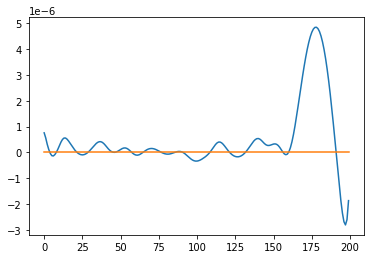

In [56]:
plt.plot([s.grad[-1].item() for s in stims])
plt.plot([0.0 for s in stims])

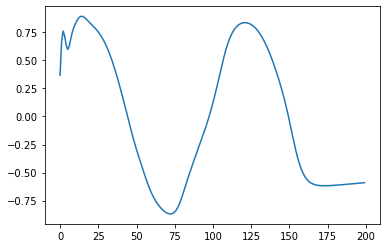

In [57]:
plt.plot([s[-1].item() for s in stims])

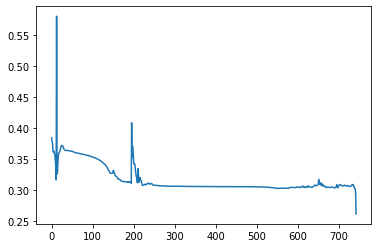

In [10]:
plt.plot(cpn_losses)

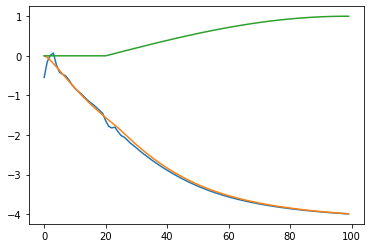

In [11]:
plt.plot(pred[0,:].detach().numpy())
plt.plot(all_obs[0,:].detach().numpy())
plt.plot(target[0,:,0].detach().numpy())
plt.show()


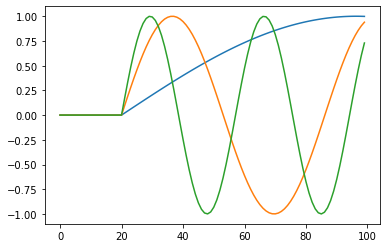

In [22]:
plt.plot(target[1,:,0].detach().numpy())
plt.plot(target[128,:,0].detach().numpy())

plt.plot(target[-1,:,0].detach().numpy())


nan
nan
2.5291595458984375


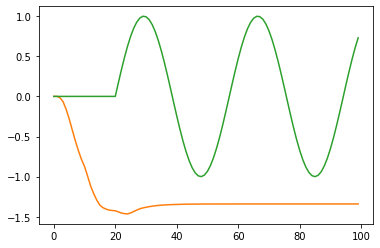

In [13]:
# Check fit of current ben and cpn
ben = recent_ben
cpn.reset()
ben.reset()

stims = []
pred = torch.zeros(batch_size, steps)
all_obs = torch.zeros(batch_size, steps)
noised = make_noised_cpn(cpn)
s = stim.StimulusGaussianExp(1, 1, batch_size=256, pad_right_neurons=1)
thing = [Thing(init=x.item()) for x in target[:, 0, 0].detach().numpy()]

#cpn_temp = CPNNoiseyPassthrough(cpn)
for tidx in range(steps):
    obs = [t.observe() for t in thing]
    new_obs = torch.tensor(obs, requires_grad=False).reshape(256,1)
    all_obs[:, tidx:tidx+1] = new_obs
          
    ind = target[:, tidx, 1:3].reshape(256,2)
    cpn_in = torch.cat((new_obs, ind), axis=1)
    new_stim = cpn(cpn_in)

    ben_in = torch.cat((new_obs, new_stim, ind), axis=1)
    cur_pred = ben(ben_in)
    pred[:, tidx] = cur_pred.squeeze()
        
    s.add(new_stim)
    n = s.get_next().detach().numpy()

    obs = []
    for bidx in range(batch_size):
        thing[bidx].step(n[bidx, 0].item())


loss = torch.nn.MSELoss()
print(loss(pred, target[:, :, 0]).item())
print(loss(pred, all_obs).item())
print(loss(all_obs, target[:, :, 0]).item())

plt.plot(pred[-1, :].detach().numpy())
plt.plot(all_obs[-1, :].detach().numpy())
plt.plot(target[-1, :, 0].detach().numpy())

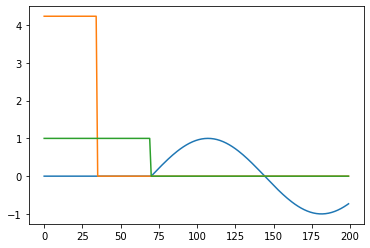

In [4]:
plt.plot(target[-1, :, 0].detach().numpy())
plt.plot(target[-1, :, 1].detach().numpy())
plt.plot(target[-1, :, 2].detach().numpy())